In [7]:
import json
import pandas as pd
import plotly.express as px
import os

In [8]:
def read_file(path):
    with open(path, "r") as f:
        data = f.read()
    return json.loads(data)["results"]


def short_name(name):
    if name == "gpt-3.5-turbo-1106":
        return "gpt-3.5-turbo"
    if "/" in name:
        name = name.split("/")[1]
    for k in ["-Instruct", "-preview"]:
        if k in name:
            name = name.split(k)[0]
    return name

In [9]:
with open("merged_run_outputs/merged.json") as f:
    results = json.loads(f.read())

In [15]:
data = []
data2 = []

for key, value in results.items():
    x = key.split("|")
    name, fromtype = x[0].split("---DESCRIPTION-")
    desc_model = x[1].split("---COMPARISON")[0]
    cmp_model = x[2]
    values = value["total_tallies"]
    desc_model = short_name(desc_model)
    cmp_model = short_name(cmp_model)

    if cmp_model.startswith("Qwen1.5"):
        continue
    
    row = (name, fromtype, desc_model, cmp_model)
    data.append(row + ("human", values["Human"]))
    data.append(row + ("llm", values["LLM"]))
    data.append(row + ("invalid", values["Invalid"]))

    total = values["Human"] + values["LLM"]
    if total > 0:
        data2.append((desc_model, cmp_model, name, fromtype, float(values["LLM"]) / total))

data2.append(("gpt-4-1106", "Humans", "product", "from_json_details", 0.29))
data2.append(
    (
        "gpt-4-1106",
        "Humans",
        "paper",
        "write_xml_paper_abstract_control_word_count",
        0.46,
    )
)
data2.append(("gpt-3.5-turbo", "Humans", "product", "from_json_details", 0.28))
data2.append(
    (
        "gpt-3.5-turbo",
        "Humans",
        "paper",
        "write_xml_paper_abstract_control_word_count",
        0.60,
    )
)

# MODELS = [
#     "gpt-4-1106",
#     "gpt-3.5-turbo",
#     "Mixtral-8x22B",
#     "Qwen1.5-4B",
#     "Qwen1.5-14B",
#     "Qwen1.5-72B",
#     "Meta-Llama-3.1-8B",
#     "Meta-Llama-3.1-70B",
# ]
# def add(name, desc_model, ftype, data):
#    for m, v in zip(MODELS, data):
#        data2.append((desc_model, m, name, ftype, v))
# # add("product", "gpt-4-1106", "from_json_product_listing", [0.87, 0.90, 0.96, 0.56, 0.82, 0.86, 0.86, 0.79])
# # add("product", "gpt-4-1106", "from_json_details", [0.88, 0.89, 0.95, 0.53, 0.84, 0.83, 0.84, 0.89])
# # add("product", "gpt-3.5-turbo", "from_json_details", [0.62, 0.74, 0.79, 0.52, 0.67, 0.64, 0.70, 0.64])

df = pd.DataFrame(
    data, columns=["name", "ftype", "desc_model", "cmp_model", "rtype", "rvalue"]
)
df2 = pd.DataFrame(data2, columns=["desc_model", "cmp_model", "name", "ftype", "value"])
df2 = df2[df2.desc_model != "Llama-3.3-70B"]

product / from_json_details


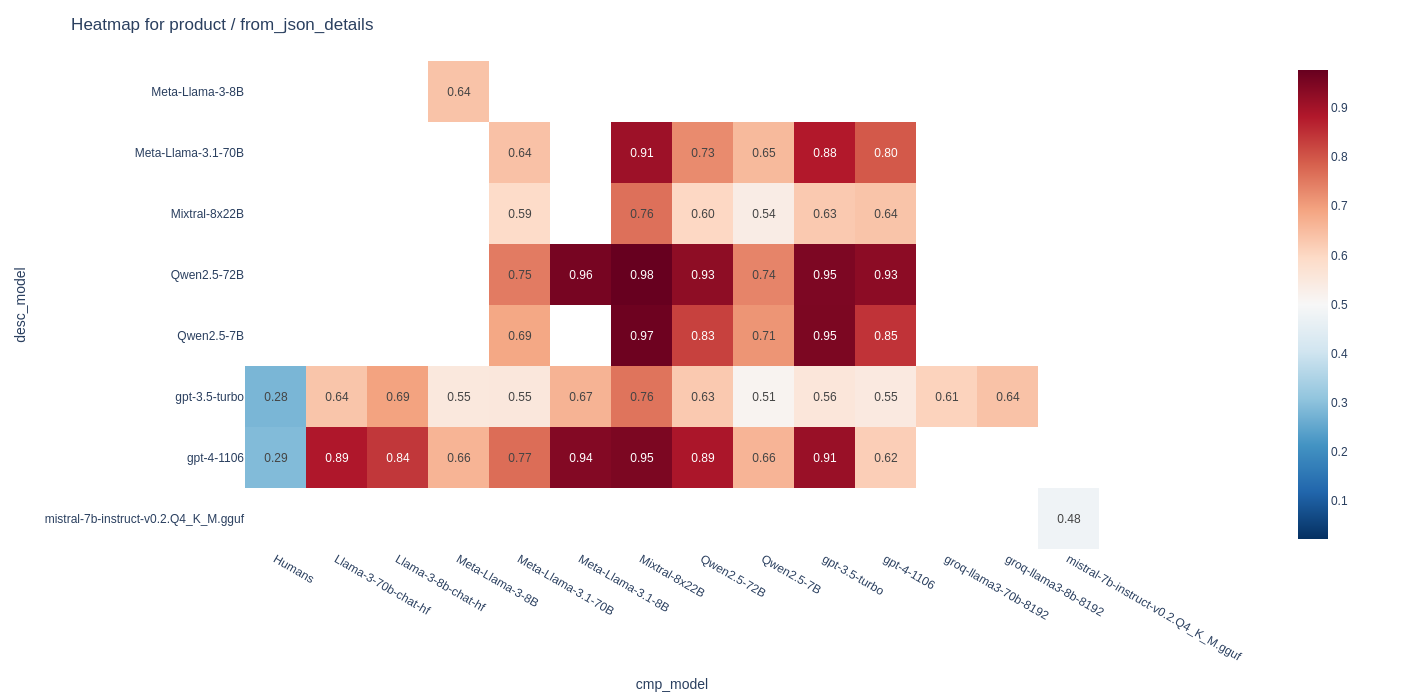

paper / write_xml_paper_abstract_control_word_count


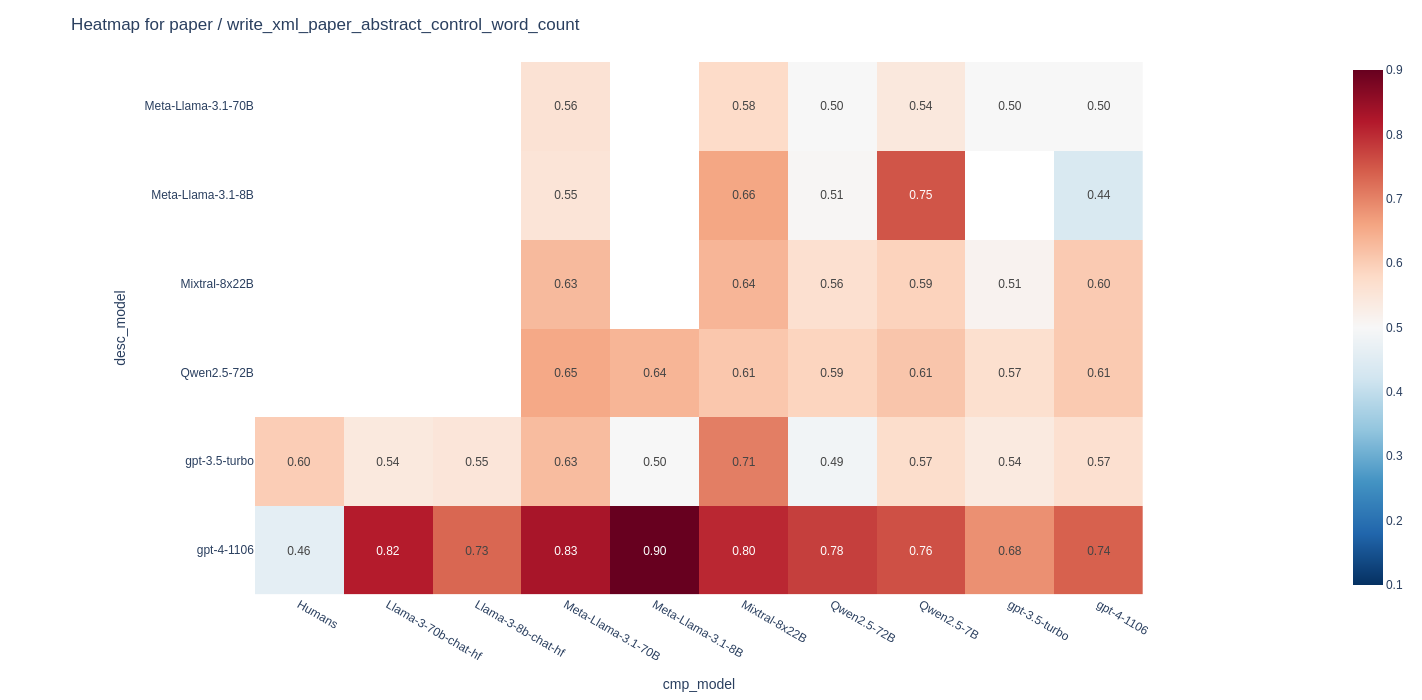

product / from_json_product_listing


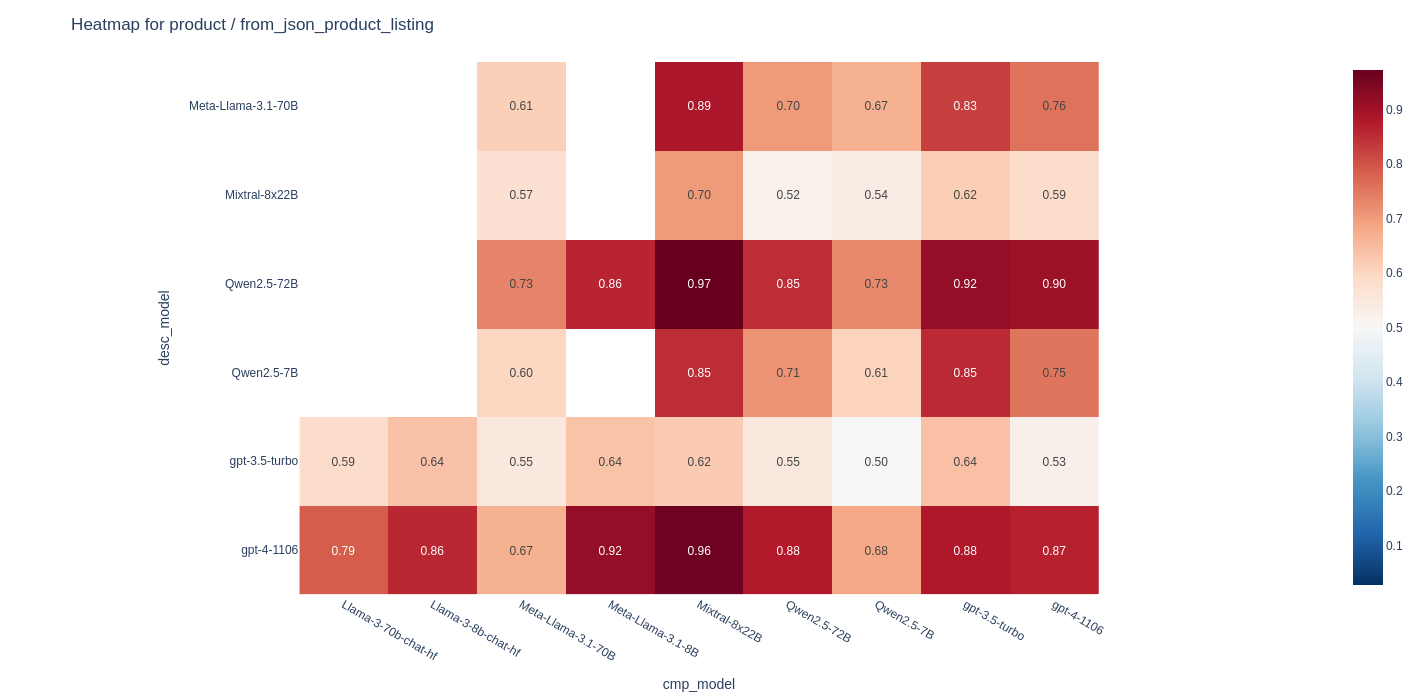

proposal / from_json_details


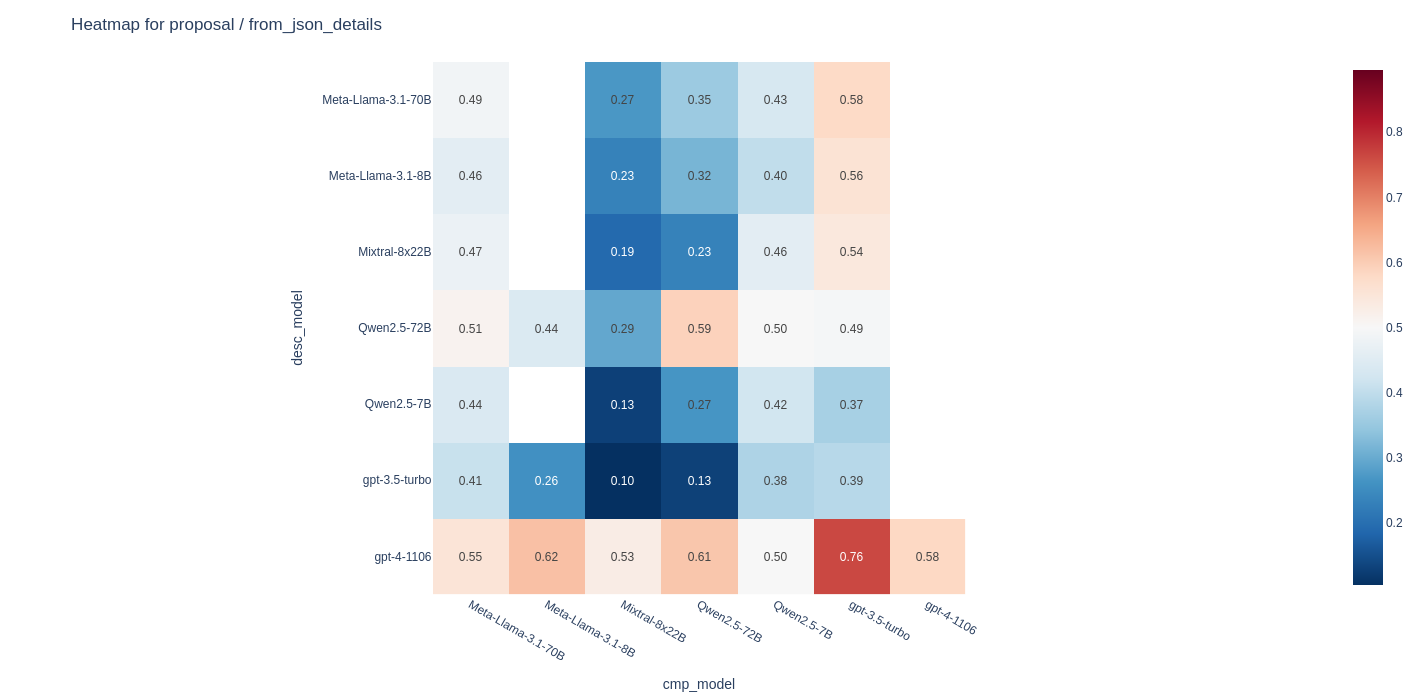

proposal / include_descriptions


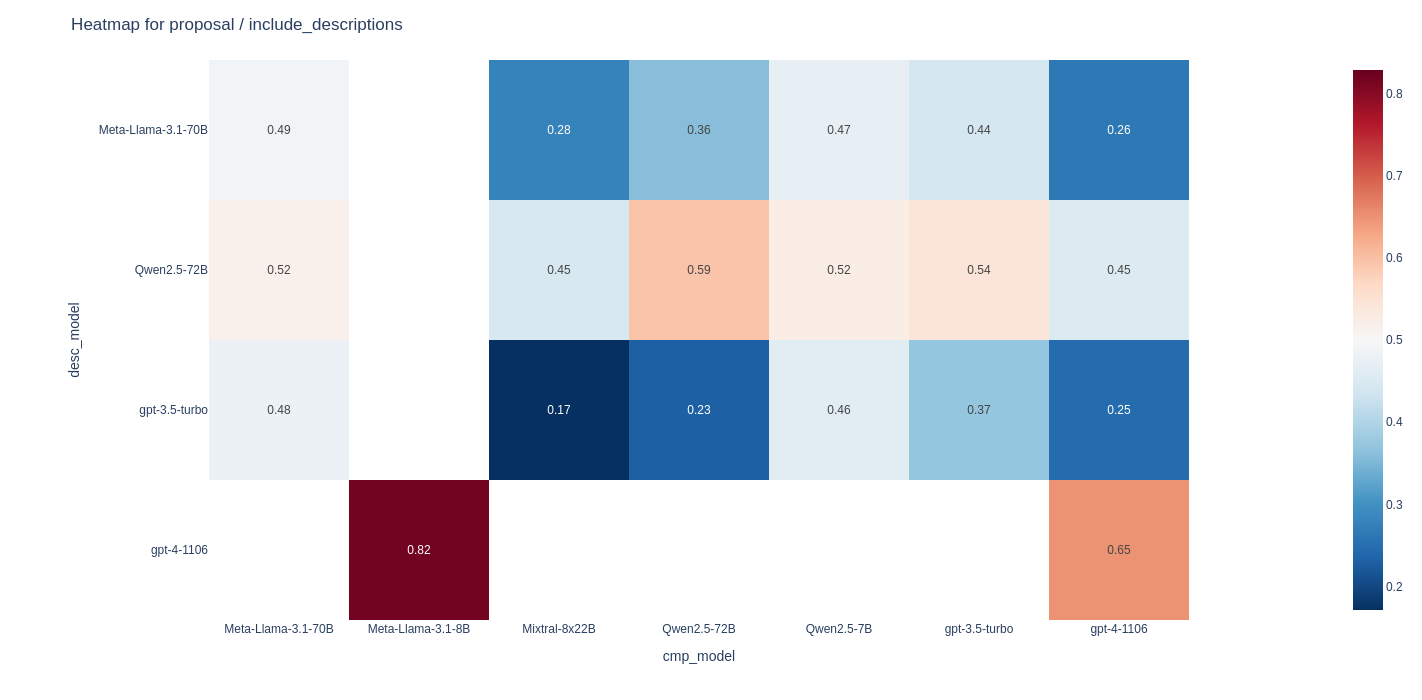

product / from_json_non_native


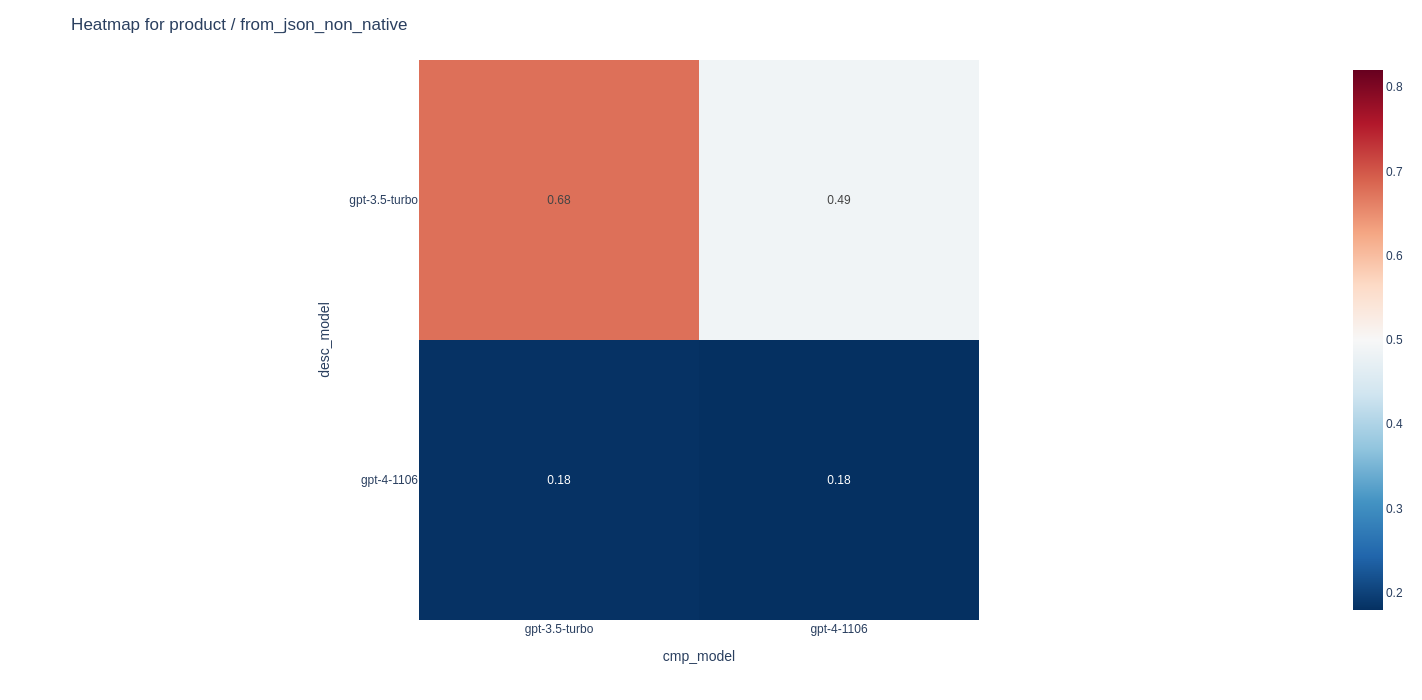

product / from_json_old_person


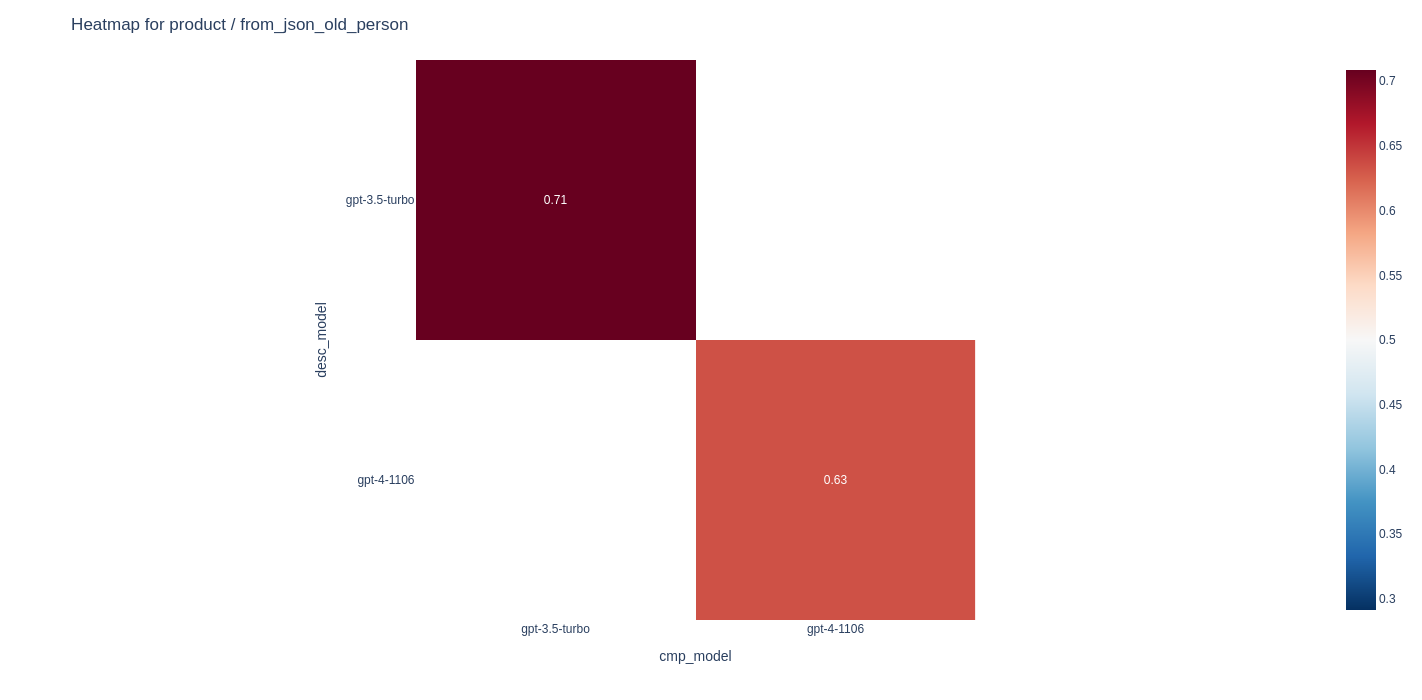

movie / from_title_and_year


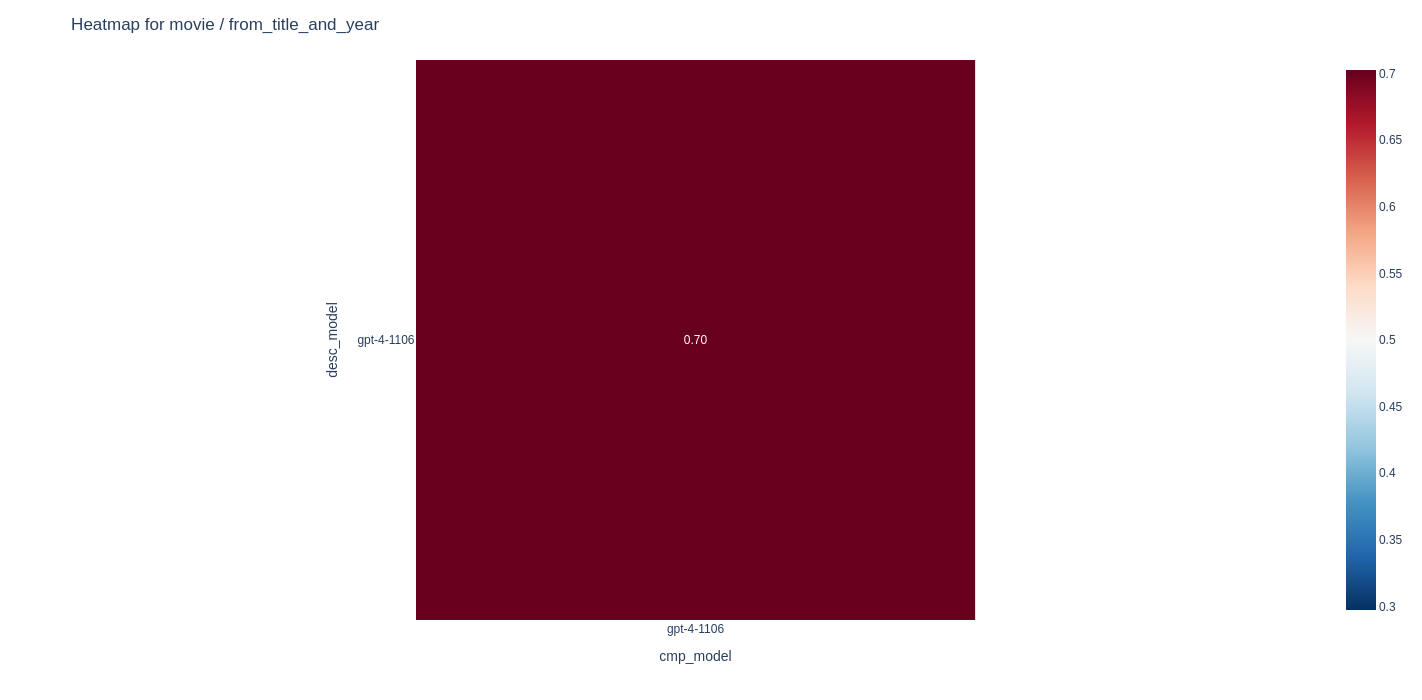

paper / write_xml_paper_abstract


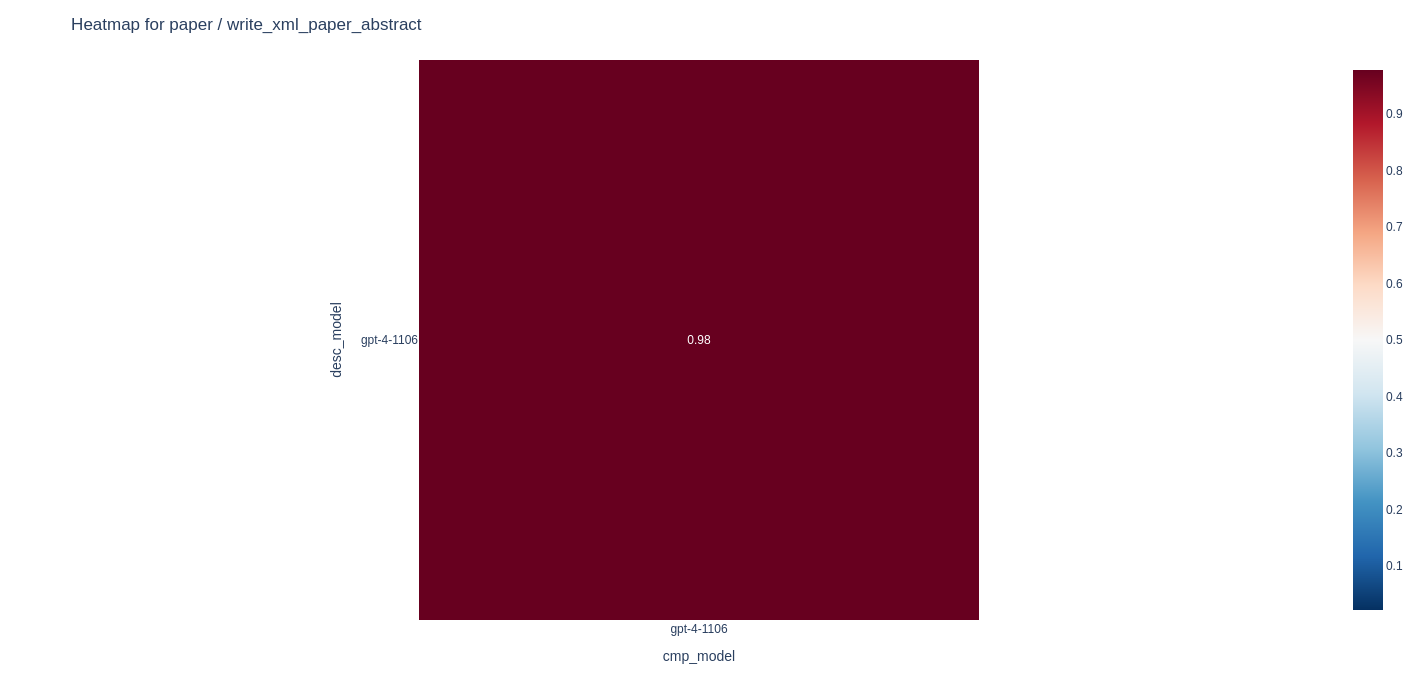

product / from_json_avg_human


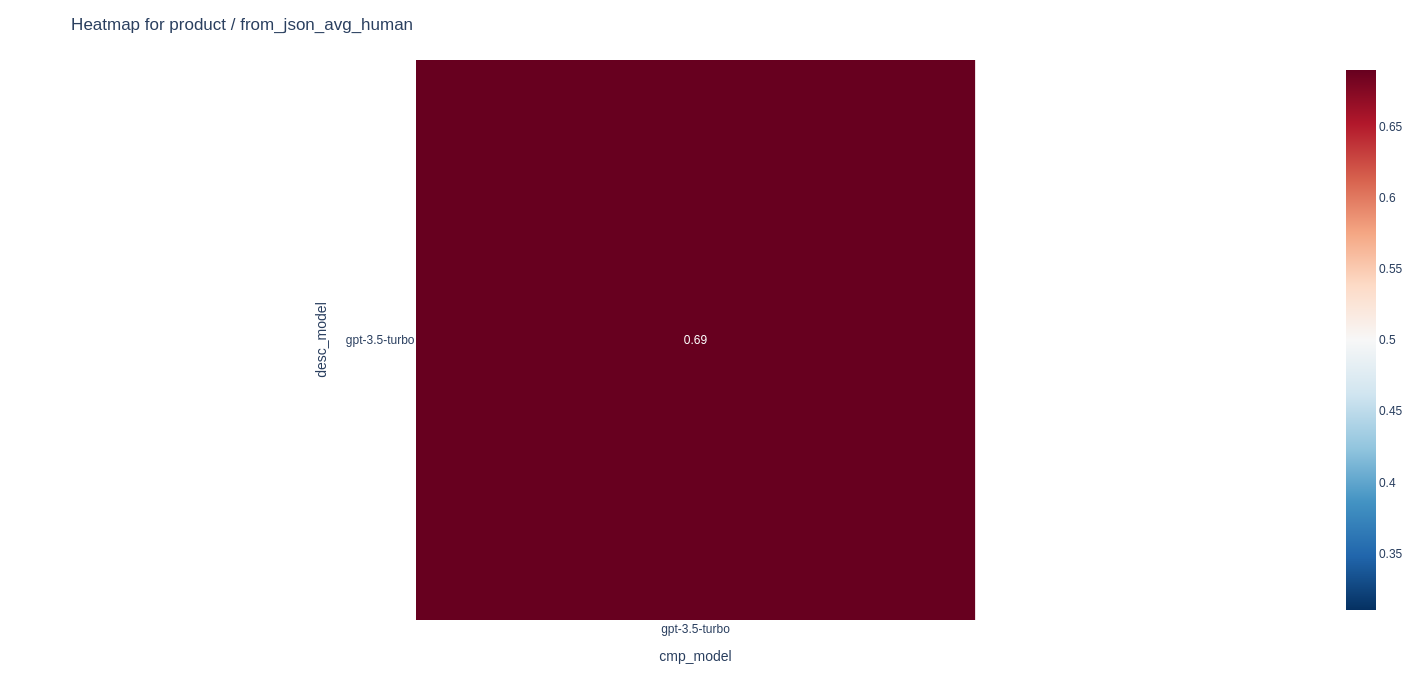

product / short_and_pointed


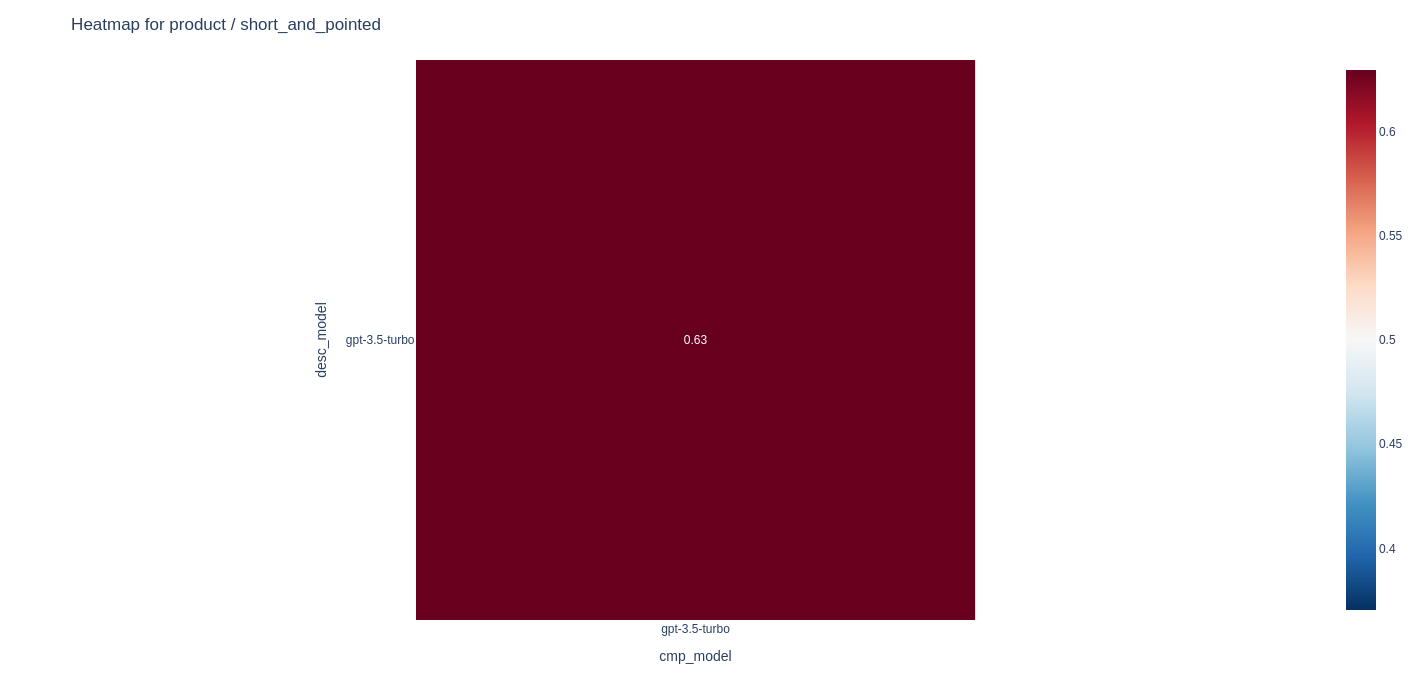

In [16]:
for name, ftype in list(df[["name", "ftype"]].value_counts().index):
    print(name, "/", ftype)
    d = df2[(df2.ftype == ftype) & (df2.name == name)]
    d = d.groupby(["desc_model", "cmp_model"], as_index=False).agg({"value": "mean"})

    tab = d.pivot(index="desc_model", columns="cmp_model", values="value")
    fig = px.imshow(
        tab,
        text_auto=".2f",
        color_continuous_scale="RdBu_r",
        height=700,
        color_continuous_midpoint=0.5,
    )
    fig.update_layout(
        plot_bgcolor="rgba(0, 0, 0, 0)", title=f"Heatmap for {name} / {ftype}"
    )
    fig.show()
